# Machine Learning II: Assignment #4

> Group 6 members: Martina Furlanis, Yue Hou, Hsi-Wei Wang, Yifan Xing, Zhida Zhang

Assignment 4 (Due: Fri, May 14, 2021)

The devised program estimates robustly, given very noisy and very sparse data of infected and recovered of a past epidemic, the basic reproduction number of the SIR model. To keep computation in limit, we assume gamma=1. The SIR model is implemented in a minimal and optimal way, using scaled variables and a scaled time. Only the ODE part is numerically integrated that needs to be integrated. The noisy number of infected and the number of recovered are highly correlated. This relationship helps MCMC infer the parameters. 

Get familiar with the commented MCMC code below.

Task:
Change the program to the SIRD model, by including (D)eaths, with rate $\mu$. Fix not only $\gamma=1$ but also $\beta=2.5$ (or to a higher value of your choice). 
Infer the death rate $\mu$, given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves.
If you want, you can try to optimze the code (optional, very very hard). 
Also optional is: Does the inference for $\mu$ work, if $S(t)$ and/or $R(t)$ are not given ?
You may use these (initial) conditions/parameters: $$i0 = 0.01, s0 = 0.99, r0 = 0, d0 = 0, f = 3.0, timestep = 0.5.$$
You may assume values for the respective $\sigma$'s (log-normal noises) in the range of $0.2-0.4$, but not lower than $0.1$. Good luck and have fun.

In [1]:
# Assignment 4: SIR model, MCMC for R0
# Jan Nagler
# based on https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_API_introduction.htm
import numpy as np
import matplotlib.pyplot as plt
%precision 4 
%matplotlib inline
import pymc3 as pm #install if necessary
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore") 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

### SIRD Model

- Our SIRD model keeps three compartments: Recovered, Infected and Dead
- We keep *gamma = 1* and *beta = 2.5*, *R0 = 2.5/1+Mu*

<br>
$$ dR/dt = \gamma * I $$ <br>
$$ dI/dt = \beta * (1 - R - I - D)  + \gamma * I + \mu * I $$ <br>
$$ dD/dt = \mu * I$$ <br>
To distinguish with the mean of Normal distribution, death rate is denoted by 'Mu' and set to 0.01.

The noise of R, I, and D are set to 0.20, 0.60, 0.2.

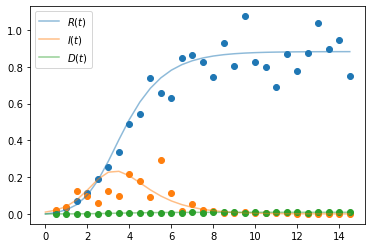

In [2]:
# Define initial conditions of SIRD model
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0
d0 = 0.00 #fraction of dead at time t0=0
f = 3.0 #3.0 # time factor, defines total time window range
timestep_data = 0.5 # dt for data (e.g., weekly)

# ODE SIRD system, only parameter p[0]=Mu, for scaled time t/gamma (optimized, and 1=gamma,beta = 2.5)
def SIRD(y, t, p):
    #ds = -2.5*(1-y[0]-y[1]-y[2])*y[1] # we do not need susceptibles as S=1-I-R-D is determ dependent on i and r
    #dr = y[1] #component 0 = recovered, gamma=1 (will be returned directly)
    di = 2.5*(1-y[0]-y[1]-y[2]) - y[1]- p[0]*y[1] #component 1 = infected, gamma=1 (SIRD in one line)
    dd = p[0]*y[1]
    return [y[1], di, dd] # return r(ecov) and i(nfect) and d(ead)

times = np.arange(0,5*f,timestep_data)

#ground truth (fixed gamma=1, beta = 2.5, then R0=beta, time scale to t/gamma)
Mu = 0.01

# Create SIR curves
y = odeint(SIRD, t=times, y0=[r0, i0, d0], args=([Mu],), rtol=1e-8) # r0 recovered, i0 infected,d0 dead  at t0

# Observational model for muliplicative noise
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20, 0.60, 0.2]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.legend()
plt.show()

#### The above figure shows the noise of the three variances for I(infected), R(ecovered) and D(ead) and their original curve.

### Model

- We choose mu as the only parameter for the MCMC model, since mu should be positive or zero, we set pm.Bound(,lower = 0.0).
- To test if the model survives noise, we set the mean of mu to 0.02 (not the same with the surrogate data).
- To get as much samples as we could, we tested 1000 samples. The results are quite satisfying.

Sequential sampling (2 chains in 1 job)
NUTS: [Mu, sigma]


Sampling 2 chains for 1_000 tune and 1_200 draw iterations (2_000 + 2_400 draws total) took 1123 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.14,0.02,0.11,0.18,0.0,0.0,3335.0,1663.0,1.0
sigma[1],0.66,0.09,0.50,0.84,0.0,0.0,2239.0,1280.0,1.0
sigma[2],0.22,0.03,0.17,0.28,0.0,0.0,2803.0,1507.0,1.0
Mu,0.01,0.00,0.01,0.01,0.0,0.0,3194.0,1463.0,1.0


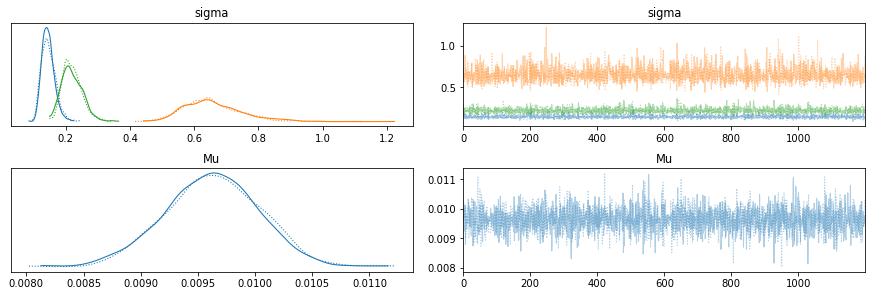

In [3]:
# ODE system container
sird_model = DifferentialEquation(
    func = SIRD,
    times = np.arange(timestep_data,5*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 3, #r(ecovered) ,i(nfected),d(ead) are states
    n_theta = 1, # Mu only parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0],sigma[1],and sigma[2], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=3 )

    #Prior :mu is bounded from below(lower = 0.01),(Mu,mu = 0.02,sigma = 3)
    Mu = pm.Bound(pm.Normal,lower=0.0)('Mu',0.02,3)
    
    # Our deterministic curves
    sird_curves = sird_model( y0=[r0, i0, d0], theta=[Mu] ) # assume gamma = 1, beta = 2.5

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=pm.math.log(sird_curves), sd=sigma, observed=yobs) # variances via sigmas, data=yobs
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(1200, step=step, cores=1, random_seed=44) #set here number of cores, to adapt for hardware

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

### Takeaways

From the result we can see that the model works very well.

- In the first part we set Mu = 0.01, and we get from the model a mean of Mu = 0.01
- The mean of sigma is set initially to [0.2,0.6,0.2], and the approximate mean of sigma is [0.15,0.65,0.22]. We can see that our result is very close
- The dashed and solid line for each sigma are very close, showing a rather solid simulation. 
- The dashed and solid line for Mu have are quite similar overall, which is considered a pretty good result.



array([[<AxesSubplot:ylabel='sigma\n1'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma\n2'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='sigma\n0', ylabel='Mu'>,
        <AxesSubplot:xlabel='sigma\n1'>, <AxesSubplot:xlabel='sigma\n2'>]],
      dtype=object)

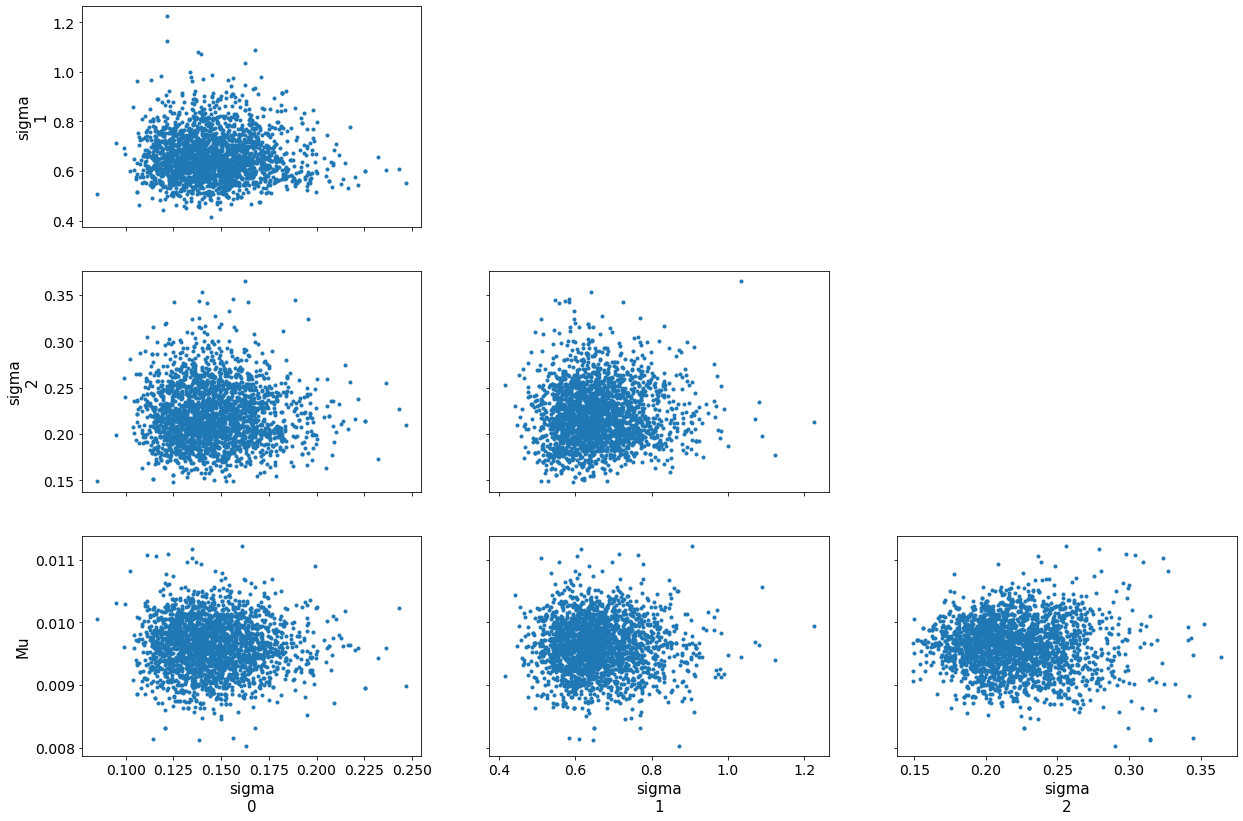

In [4]:
pm.pairplot(trace)

### Takeaways

- We see from the above plot that Mu has almost no correlation with the other three variances sigma[0], sigma[1] and sigma[2].